In [1]:
import process_data
from process_data import get_dfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit  
from scipy.special import voigt_profile
from scipy.ndimage import gaussian_filter1d
import pickle
import os
import importlib
importlib.reload(process_data)

<module 'process_data' from '/Users/xnimir/Desktop/Sn exp 2024/process_data.py'>

In [2]:
def gaussian(x, A, mu, sigma, B):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + B

In [3]:
def standard_lorentzian(x, amplitude, center, width, offset):
    return amplitude * width**2 / ((x - center)**2 + width**2) + offset

In [4]:
def super_lorentzian(x, amplitude, center, width, power, offset):
    # Generalized Lorentzian with adjustable power for wider wings
    return amplitude * width**power / ((x - center)**power + width**power) + offset

In [5]:
def voigt(x, amplitude, center, g_width, l_width, offset):
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    return basic_voigt + offset

In [6]:
def modified_voigt(x, amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point):
    penalty = 1e6 * (1 - np.exp(-g_width**2 / (1e-4))) if g_width < 1e-4 or l_width < 1e-4 else 0
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    wing_enhancement = modification_factor * amplitude * (g_width**2 / ((x - center)**2 + g_width**2))**0.5
    baseline = offset + slope * np.maximum(0, x - transition_point)
    return basic_voigt + wing_enhancement + baseline + penalty
   

In [7]:
def gaus_fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    initial_guess = [np.max(y), x[np.argmax(y)], np.std(x), 0]
    bounds = ([0, 0, 0, 0], [np.inf, np.max(x), np.inf, np.inf])
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, sigma=np.sqrt(y), absolute_sigma=True)
    y_fit = gaussian(x_fit, *popt)

    fwhm = 2.355 * popt[2] * 1E6
    fit_errors_g = np.sqrt(np.diag(pcov))
    mu_error = fit_errors_g[1]

    return x_fit, y_fit, popt, pcov, fwhm

In [8]:
def focus_on_peak(x, y, fit_width):
    # Find the x-value of the peak (maximum y-value)
    peak_index = np.argmax(y)
    peak_x = x[peak_index]
    
    # Define the fitting window around the peak
    x_min = peak_x - fit_width
    x_max = peak_x + fit_width
    
    # Filter x and y values within the fitting window
    mask = (x >= x_min) & (x <= x_max)
    x_subset = x[mask]
    y_subset = y[mask]
    
    return x_subset, y_subset

In [9]:
def voigt_fitting(file, x, y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)
    
    amplitude = np.max(y)
    center = x[np.argmax(y)]

    # half_max = amplitude / 2
    # indices_above_half_max = np.where(y >= half_max)[0]
    # if len(indices_above_half_max) > 1:
    #     fwhm = x[indices_above_half_max[-1]] - x[indices_above_half_max[0]]
    #     g_width = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to standard deviation
    # else:
    #     g_width = (x[-1] - x[0]) / 10  # Fallback: estimate width as a fraction of x range
    g_width = 200E-6 / (2 * np.sqrt(2 * np.log(2)))
    l_width = g_width / 2  # Start with l_width smaller than g_width
    offset = np.min(y)

    weights = 1 / np.sqrt(y + 1)
    # weights = 1 / (np.sqrt(y + 1) + np.abs(x - center) * 100)


    # lower_bounds = [0, np.min(x), 0, 0, -np.inf, 0]  # Amplitude >= 0
    # upper_bounds = [np.inf, np.max(x), np.max(x) - np.min(x), np.max(x) - np.min(x), np.inf, 1]  # No tight upper bounds

    if any(substring in file for substring in ['Sn-114', 'Sn-122_', 'Sn-124_']):  # fixing weird shape
        # x, y = focus_on_peak(x, y, fit_width=0.0009)
        slope = 50000
        modification_factor = 0.1
        transition_point = 0.005
        popt, pcov = curve_fit(modified_voigt, x, y, 
                        p0=[amplitude, center, g_width, l_width, offset, slope, modification_factor, transition_point])
        y_fit = modified_voigt(x_fit, *popt)
     
    else:
        popt, pcov = curve_fit(voigt, x, y, 
                            p0=[amplitude, center, g_width, l_width, offset],
                            sigma = weights)
                            # bounds=(lower_bounds, upper_bounds))
        y_fit = voigt(x_fit, *popt)


    g_width_fit = popt[2]  # Extract Gaussian width from popt
    l_width_fit = popt[3]  # Extract Lorentzian width from popt
    fwhm = np.sqrt(g_width_fit**2 + l_width_fit**2) * 1E6 # MHz

    return x_fit, y_fit, popt, pcov, fwhm

In [ ]:
def get_scatter_plot(data_df, time_df, freq_df, file):
    x = data_df['Bin center']
    y = data_df['Count raw']
    # y_1 = gaussian_filter1d(data_df['Count raw'], sigma=2)
    # y = data_df['Total_count']
    # y_norm = data_df['Norm count']
    x_fit_g, y_fit_g, popt_g, pcov_g, fwhm_g = gaus_fitting(x, y)
    x_fit_v, y_fit_v, popt_v, pcov_v, fwhm_v = voigt_fitting(file, x, y)

    x_adjust_fit = x_fit_v - popt_v[1]
    x_adjust = x - popt_v[1]

    # plt.figure()
    plt.errorbar(x_adjust*1E6, y, yerr=np.sqrt(y), fmt='o', capsize=3) # for freq centering at 0
    plt.plot(x_adjust_fit*1E6, y_fit_v, color='red')
    # plt.errorbar(x, y, yerr=np.sqrt(y), fmt='o', capsize=3) # for no freq centering
    # plt.plot(x_fit_v, y_fit_v, color='red')
    plt.xlim(-500,500) # for freq centering at 0
    plt.title(f'{file}')
    plt.xlabel('frequency (MHz)') # for freq centering at 0
    # plt.xlabel('frequency (THz)')
    plt.ylabel('binned counts')
    # print(popt_v[1])
    # # plt.legend()

    # # label_g = f'Gaussian: mu={popt_g[1]:.6f} THz\nfwhm={fwhm_g:.2f} MHz'
    # # plt.text(0.95, 0.95, label_g, fontsize=10,
    # #                     verticalalignment='top', horizontalalignment='right',
    # #                     transform=plt.gca().transAxes) 
    
    # label_v = f'mu={popt_v[1]:.6f} THz\nfwhm={fwhm_v:.2f} MHz'
    # plt.text(0.95, 0.95, label_v, fontsize=10,
    #                     verticalalignment='top', horizontalalignment='right',
    #                     transform=plt.gca().transAxes) 
    plt.show()

    # plt.title('Frequency')
    # plt.scatter(freq_df['Bin center'], freq_df['Count raw'], color='red')
    # plt.show()
    # plt.title('Time')
    # plt.scatter(time_df['Bin center'], time_df['Count raw'])
    # plt.show()

    return popt_v[1]

In [14]:
def main(folder_path):
    peak_data = [] 
    scaled_dfs = []
    for order, (filename, scaled_df, time_df, freq_df, isotope) in enumerate(get_dfs(folder_path), start=1):
        peak_freq = get_scatter_plot(scaled_df, time_df, freq_df, filename)
        peak_data.append([isotope, peak_freq, order])
        scaled_dfs.append(scaled_df)

    return peak_data, scaled_dfs, filename # peak data is list of tuples, scaled_dfs is list of dataframes

In [42]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set10/'
    peak_data, scaled_dfs, filename = main(folder_path)
#     print(peak_data)
# single_set()

In [121]:
def multiple_sets():
    folder_base_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set'  
    results_dict = {} 

    for set_number in range(1,11):  # iterated from n to n-1
        folder_path = f'{folder_base_path}{set_number}/'  
        peak_data = main(folder_path) # peak data = [isotope, peak, order]

        # first organize by isotope 
        isotopes_dict = {}
        for (isotope, peak, order) in peak_data: # unpack tuple 
            if isotope not in isotopes_dict:
                isotopes_dict[isotope] = []
            isotopes_dict[isotope].append((peak, order))  
            
        results_dict[set_number] = {} # looks like {1: {120: [{'peak': np.float64(195.2373446406191), 'order': 1}

        for isotope, peak_order_list in isotopes_dict.items():
            results_dict[set_number][isotope] = []  # Initialize list for each isotope

            for peak, order in peak_order_list:
                results_dict[set_number][isotope].append({
                    'peak': peak,
                    'order': order
                })
        
    with open('results_dict.pkl', 'wb') as file:
        pickle.dump(results_dict, file)

# multiple_sets()

<!-- data looks like: {1: {120: [{'peak': np.float64(195.2373446406191), 'order': 1}

an entire set can be accessed with: set_data = results_dict[set_number]

accessing peak and order info for a specific isotope in a set: 
set_data = results_dict[set_number].get(isotope, [])
for entry in set_data:
    peak = entry['peak']
    order = entry['order']

specific isotope across all sets can be accessed with: 
isotope_data = {}
for set_number, set_data in results_dict.items():
    if isotope in set_data:
        isotope_data[set_number] = set_data[isotope] -->

In [4]:
def get_pickled_data():
    with open('results_dict.pkl', 'rb') as file:
        results_dict = pickle.load(file)
    return results_dict

In [7]:
def replace_with_averages(set_data):
    new_set_data = {}
    
    for isotope, peak_order_list in set_data.items():
        # Sort by order
        sorted_peaks = sorted(peak_order_list, key=lambda x: x['order'])
        
        current_group = []
        new_peaks = []
        
        for i, entry in enumerate(sorted_peaks):
            current_group.append(entry)
            
            is_last = i == len(sorted_peaks) - 1
            is_not_consecutive = (not is_last and 
                                sorted_peaks[i + 1]['order'] != entry['order'] + 1)
            
            if is_last or is_not_consecutive:
                # If group has consecutive orders (2 or more points)
                if len(current_group) >= 2:
                    # Calculate average
                    avg_peak = sum(item['peak'] for item in current_group) / len(current_group)
                    avg_order = sum(item['order'] for item in current_group) / len(current_group)
                    
                    # Add single averaged entry
                    new_peaks.append({
                        'peak': avg_peak,
                        'order': avg_order
                    })
                else:
                    # Keep original entry if not part of consecutive group
                    new_peaks.append(current_group[0])
                
                current_group = []
        
        if new_peaks:
            new_set_data[isotope] = new_peaks
    
    return new_set_data

In [8]:
def sliding_window_calc(set_data):
    peaks_120 = set_data[120]  # List of {'peak': value, 'order': value}
    peaks_120 = sorted(peaks_120, key=lambda x: x['order'])  # Ensure data is sorted by order

    results = []

    # Handle cases where 120 is not first or last
    first_order, last_order = peaks_120[0]['order'], peaks_120[-1]['order']

    for isotope, data in set_data.items():
        for entry in data:
            if isotope == 120:
                continue  # Skip 120 

            if entry['order'] < first_order:  # Before first 120
                adjustment = entry['peak'] - peaks_120[0]['peak']
                results.append({
                    'isotope': isotope,
                    'order': entry['order'],
                    'shift': adjustment,
                    'subtracted_from': f"First 120 order {first_order}"
                })

            elif entry['order'] > last_order:  # After last 120
                adjustment = entry['peak'] - peaks_120[-1]['peak']
                results.append({
                    'isotope': isotope,
                    'order': entry['order'],
                    'shift': adjustment,
                    'subtracted_from': f"Last 120 order {last_order}"
                })

    # Handle sliding window for 120 pairs
    for i in range(len(peaks_120) - 1):
        current_120, next_120 = peaks_120[i], peaks_120[i + 1]
        avg_peak = (current_120['peak'] + next_120['peak']) / 2

        for isotope, data in set_data.items():
            if isotope == 120:
                continue  # Skip 120

            for entry in data:
                if current_120['order'] < entry['order'] < next_120['order']:
                    adjustment = entry['peak'] - avg_peak
                    results.append({
                        'isotope': isotope,
                        'order': entry['order'],
                        'shift': adjustment,
                        'subtracted_from': f"120 pair orders {current_120['order']} and {next_120['order']}",
                        'avg_peak': avg_peak
                    })

    return results

In [9]:
def calc_IS(results_dict):
    results_all_cycles = {}
    for set_number in results_dict.keys():
        set_data = results_dict[set_number] # set data for each data point  
        new_set_data = replace_with_averages(set_data) # set data that has old data but isotopes with consecutive measurements are replaced with an average
        results = sliding_window_calc(new_set_data)
        results_all_cycles[set_number] = results

        # print(results)
        
        # for isotope, peak_list in new_set_data.items(): # avg from consec
        #     peaks = [entry['peak'] for entry in peak_list]
        #     orders = [entry['order'] for entry in peak_list]
        #     plt.scatter(orders, peaks, label=f'{isotope}')


        # plt.title(f'Peak vs Order for Set {set_number}')
        # plt.xlabel('Order')
        # plt.ylabel('Peak')
        # plt.legend()
        # plt.show()
    return results_all_cycles

In [10]:
results_dict = get_pickled_data()
IS_dict = calc_IS(results_dict)

In [15]:
def plot_shift_vs_isotope(IS_dict):
    avg_IS = {}
    for set_number, results in IS_dict.items():
        isotopes = [result['isotope'] for result in results]
        shifts = [result['shift'] for result in results] # THz 
        shifts_in_MHz = shifts * np.array(1E6)

        for isotope, shift in zip(isotopes, shifts_in_MHz):
            if isotope not in avg_IS:
               avg_IS[isotope] = {'shifts': [], 'count': 0}

            avg_IS[isotope]['shifts'].append(shift)
            avg_IS[isotope]['count'] += 1 
        
    for isotope, data in avg_IS.items():
        shifts = data['shifts']
        avg_shift = np.mean(shifts)
        stddev_shift = np.std(shifts)
        count = data['count']
        sem = stddev_shift / np.sqrt(count)
    
        avg_IS[isotope] = {
            'average': avg_shift, # MHz 
            'stddev': stddev_shift,
            'count': count,  # Number of measurements
            'SEM': sem # Standard error of the mean
        }

    isotopes = list(avg_IS.keys())
    avg_shifts = [avg_IS[isotope]['average'] for isotope in isotopes]
    stddev_shifts = [avg_IS[isotope]['stddev'] for isotope in isotopes]
    count = [avg_IS[isotope]['count'] for isotope in isotopes]
    # confidence_intervals = [stddev * 1.96 / np.sqrt(n) for stddev, n in zip(stddev_shifts, count)]
    sem = stddev_shifts / np.sqrt(count)

    plt.errorbar(isotopes, avg_shifts, yerr=sem, fmt='o', ecolor='red', capsize=10, markersize=8)
    plt.scatter(120, 0, s=80)
    plt.xlabel('Isotope', fontsize = 14)
    plt.ylabel('Average Shift (MHz)', fontsize=14)
    plt.title('Average Isotope Shifts', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    print(avg_IS)
                
        # plot for individual sets shifts 
        # plt.scatter(isotope, shifts_in_GHz)
        # plt.scatter(120,0, c='r')
        # plt.title(f'Shift vs Isotope for Set {set_number}')
        # plt.xlabel('Isotope')
        # plt.ylabel('Shift (GHz)')
        # plt.show()


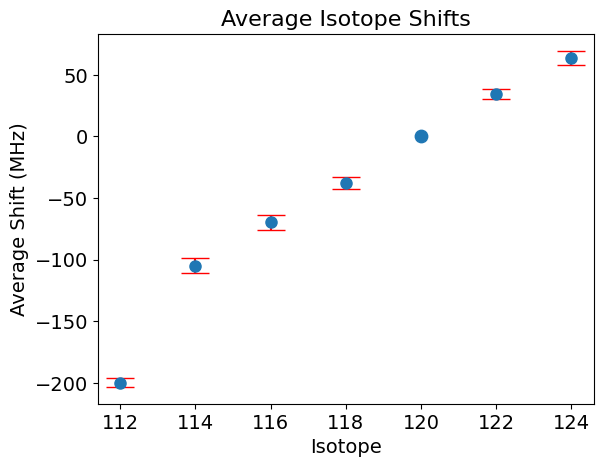

{116: {'average': np.float64(-69.77575001485548), 'stddev': np.float64(19.148008793585426), 'count': 10, 'SEM': np.float64(6.055132044466287)}, 118: {'average': np.float64(-37.480316058235985), 'stddev': np.float64(15.609136491068785), 'count': 10, 'SEM': np.float64(4.936042362022586)}, 124: {'average': np.float64(63.683321909024926), 'stddev': np.float64(18.023914365822243), 'count': 10, 'SEM': np.float64(5.69966217478276)}, 122: {'average': np.float64(34.273795165518095), 'stddev': np.float64(12.554377265613613), 'count': 9, 'SEM': np.float64(4.1847924218712045)}, 112: {'average': np.float64(-199.7105535309629), 'stddev': np.float64(4.994508273625797), 'count': 2, 'SEM': np.float64(3.5316506689731177)}, 114: {'average': np.float64(-104.78279560288684), 'stddev': np.float64(8.812558434101447), 'count': 2, 'SEM': np.float64(6.231419828355835)}}


In [16]:
plot_shift_vs_isotope(IS_dict)

In [11]:
def plot_all(peak_data, scaled_dfs, filename): # plots all isotope spectra on same plot with 120 as reference 

    sn_120_data = None
    for idx, item in enumerate(peak_data):
        if item[0] == 120:
            sn_120_data = item  # Use the first Sn-120 entry
            sn_120_index = idx  # Store its index for skipping later
            break
    sn_120_peak_freq = sn_120_data[1]

    plt.figure(figsize=(10, 6))
    
    for i, ((isotope, peak_freq, order), scaled_df) in enumerate(zip(peak_data, scaled_dfs)):
        if isotope == 120 and i != sn_120_index:
            continue
        x = scaled_df['Bin center'] 
        y = scaled_df['Count raw']
        x_aligned = x - sn_120_peak_freq
        peak_aligned = (peak_freq - sn_120_peak_freq) * 1E6
        x_fit_v, y_fit_v, popt_v, pcov_v, fwhm_v = voigt_fitting(filename, x_aligned, y) # fwhm is already in MHz

        # plt.plot(x_aligned*1E6, y, label=f'Sn-{isotope}, {peak_aligned:.2f} MHz')
        plt.plot(x_fit_v*1E6, y_fit_v, label=f'Sn-{isotope}, Peak = {peak_aligned:.2f} MHz, fwhm = {fwhm_v:.2f} MHz')

    plt.xlim(-500, 500)       
    plt.xlabel('Frequency offset Sn-120 (MHz)')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()


    return 

In [24]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set9/'
    peak_data, scaled_dfs, filename = main(folder_path)
    plot_all(peak_data, scaled_dfs, filename)
    # print(peak_data)
# single_set()

195.23738404630672


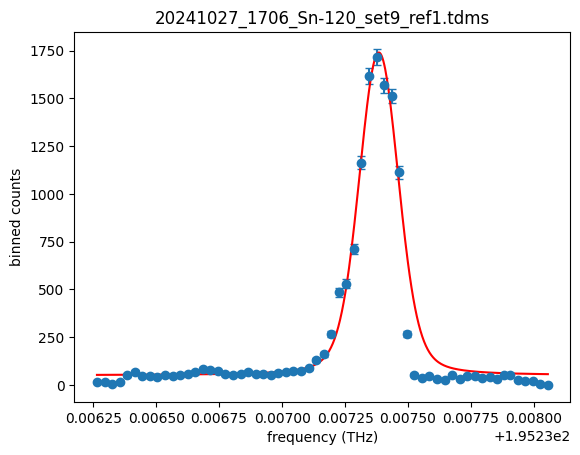

195.23739650894805


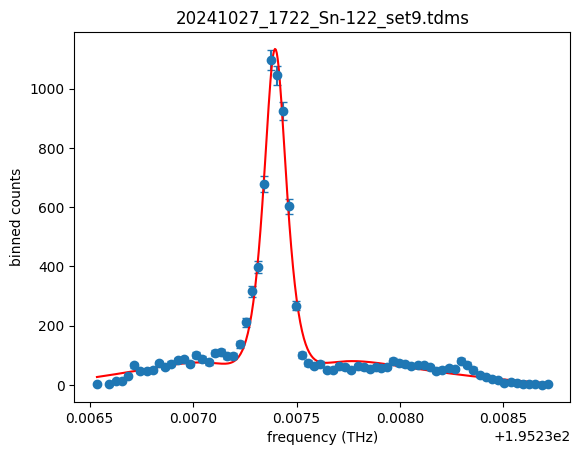

195.2374489738373


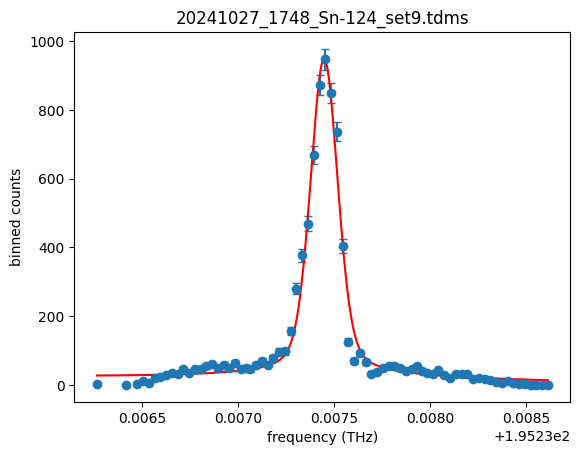

195.23736338212007


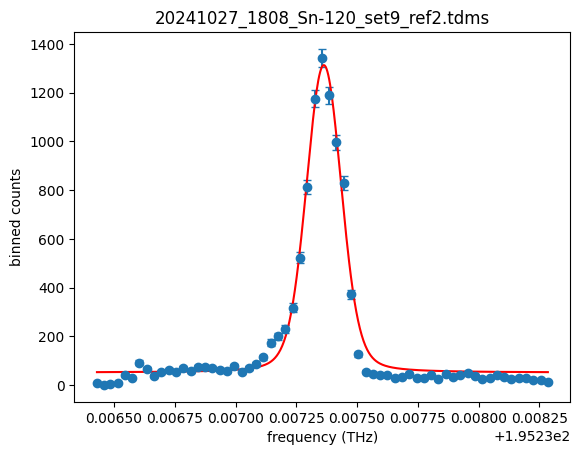

195.23731769089042


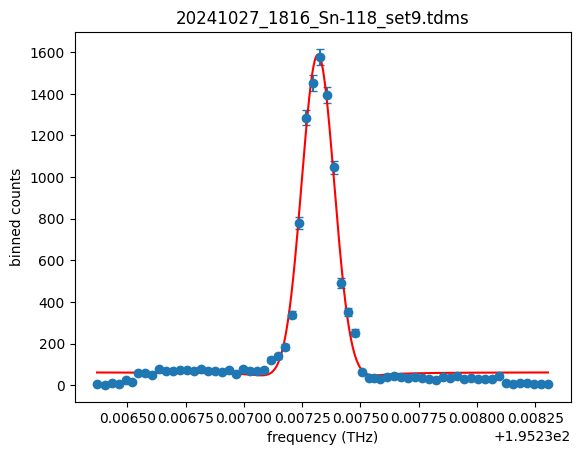

195.23732105979477


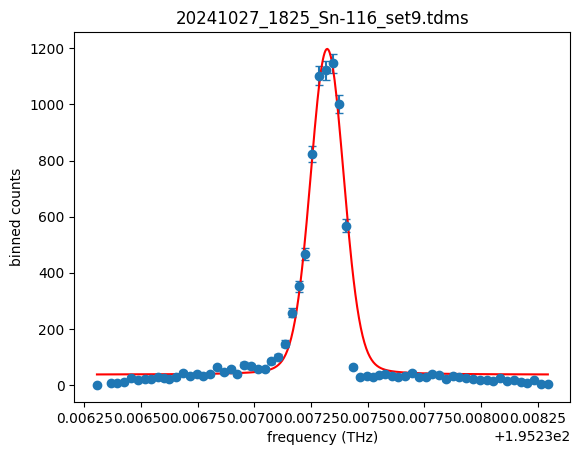

195.23738256728367


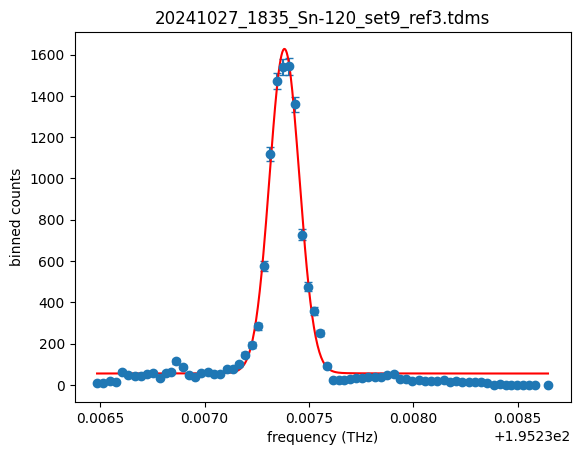

195.23726394251474


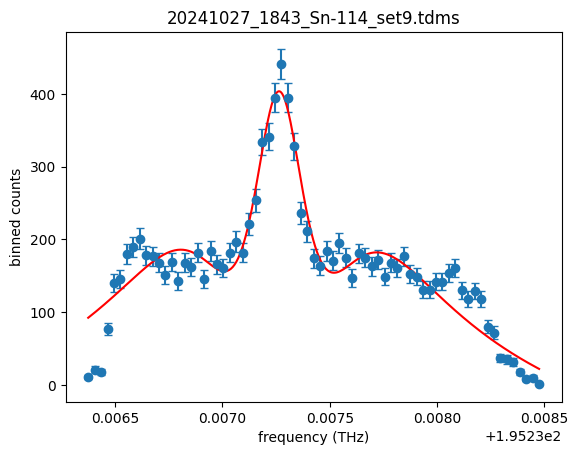

195.23737250845386


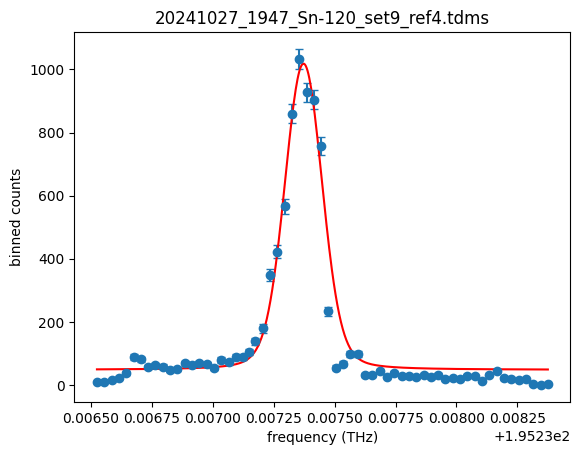

195.23717688139214


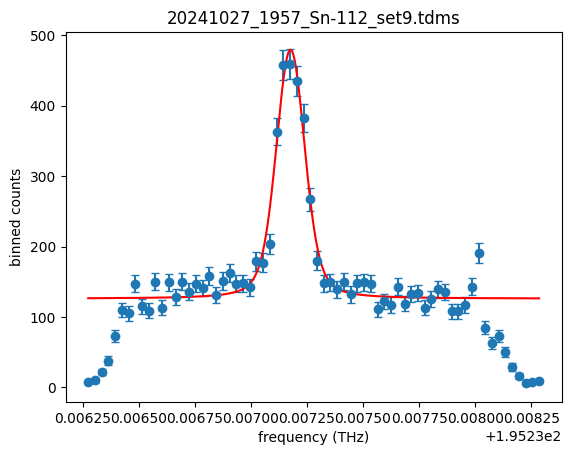

195.23737068642095


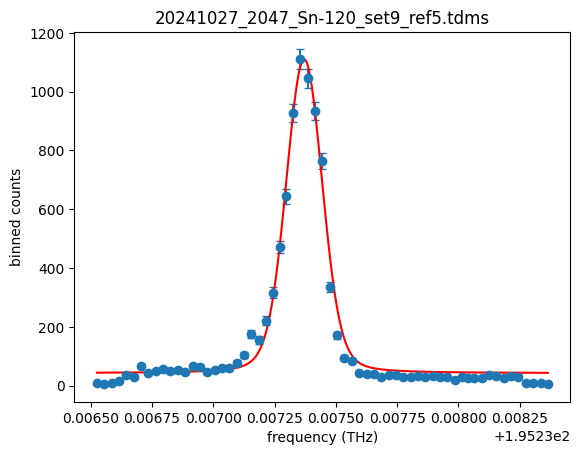

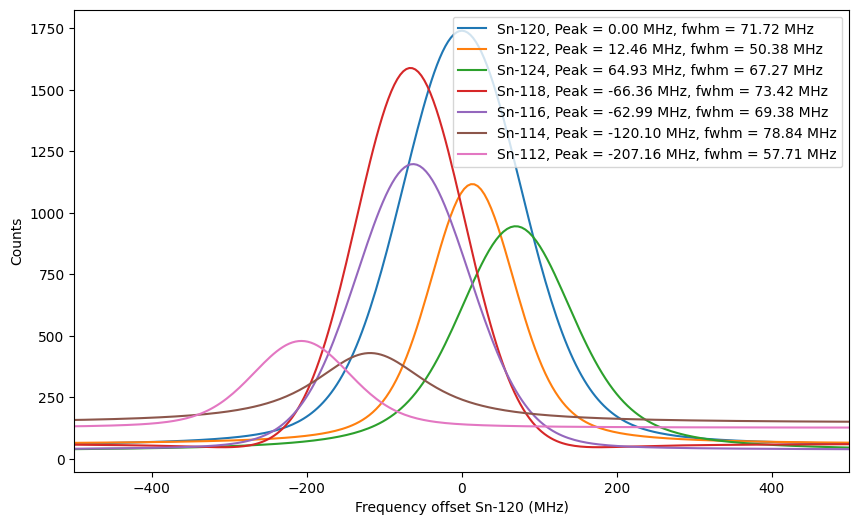

In [25]:
single_set()

In [ ]:
def king_plot():
    A = np.array([116,118,122,124])
    A_prime = 120
    new_mass_cors = []

    for i in range(len(A)):
        new_mass_cor = (A_prime*A[i])/(A_prime-A[i]) 
        new_mass_cors.append(new_mass_cor)

    shifts_freq_lit = np.array([-576.04, -270.24, 235.35, 441.15]) / 1e3 # GHz from data sheet 
    lit_err = np.array([0.15, 0.15, 0.15, 0.15]) / 1e3 * np.abs(new_mass_cors) # GHz 